# This session's goal:

## > Motivation: You need a great SDLC!
## > Frameworks: what to know
## > Have you build closer to the "prompt".

## > Things to leave you with:
### Idea of the shapes of LLM usage: pipeline vs agentic / agent & human-in-the-loop
### A start to an SDLC - by building out an app
- testing & eval
- micro vs macro

# Reinforce:
- API calls & prompt engineering
- non-determinism -> they're generative models
- structured outputs

## Things we likely wont get to:
- We shipped to prod, now what?
- Multi-modal
- Retrieval part of RAG


# Motivation

[Slides](https://docs.google.com/presentation/d/1sWKF_vyKk6ldMQ1nWX2QexZO9fPMsR9IFD_x82tNVOs/edit?usp=sharing)

# Frameworks: what to know

## 1. Reduce code you need to write
See example apps and the code we wrote or didn't write.

## 2. But also not slow you down
What are you going to need to change and when?

### Demo vs Production: they have different needs.
  - e.g. yesterday's session -- what is the prompt llama-index was using? how would you optimize it?
  - how do you reduce the variance of the outputs?

## You only really understand the value of a framework when you understand what it is trying to reduce / provide
 - hopefully you will leave you with some thoughts here today.

# Framework Spectrum

## 1. Giga libraries / all-in-one:
### Opinionated Framework + off-the-shelf implementations / ecosystem that you buy-into. 
#### E.g. langchain, llama-index, etc.
#### Large dependencies

## 2. "Construction" (glue) frameworks:
### Good at help you connect your business logic without getting in the way.
### They are neutral and allow you to bring in other tools easily.
#### E.g. FastAPI, django, pytorch, Burr, Hamilton
#### Small dependencies

## 3. Question: which do you want to use when?

###  Why is it important to understand what's being sent to the LLM?

# Sorry RAG

![Simple RAG](img/4-not-rag-focus.png)

## We wont do the retrieval part -> just the "generation" 
Retreival is just figuring out the context to add to the LLM. Need to master generation first!

> Key part is understanding the LLM calls...


# Next Section

This next section will cover:
* Building closer to the "prompt".
* Idea of the shapes of LLM usage: pipeline vs agentic / agent & human-in-the-loop
* A start to an SDLC - by building out an app
  - testing & eval
  - micro vs macro

## SDLC we'll begin to stick together:

Note 1: no fine-tuning here.

Note 2: due to time, we wont dive into automation, or model based & A/B test approaches to evals.

![Alt text](img/3-llm-virtuous-cycle.png)

## Recruiting email assistant
You're a hiring manager/recruiter and are tasked with cold or warm outreach to get candidates to interview. We're going to slowly build out a little application and try to reinforce some first principles here.

If you need our LinkedIn profiles you can find them [here](https://drive.google.com/drive/folders/1enZQYpunRFk2nj8_UVK7iExbtevKf3bH?usp=sharing).


### Refresher on calling openai

In [2]:
# set env key if you haven't
import os
#os.environ['OPENAI_API_KEY'] = .....

from openai import OpenAI

client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {"role": "system", "content": "You are Mario from Super Mario Bros. Answer as Mario, the assistant, only."}, 
    {"role": "user", "content": "Tell me a joke."},
    {"role": "assistant", "content": "Why did the computer go to the doctor? Because it had a virus! Wahaha!"},
    {"role": "user", "content": "Tell me another one."},  
  ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content='Why was the math book sad? Because it had too many problems! Mama mia!', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)


### Quick note on "prompting techniques"
These are situational -- but parking here in case you need it for the exercise.
#### Zero shot
No examples.
```
What are some interesting facts about the Eiffel Tower?
```

#### One-to N shot prompting
In one-shot prompting, you provide one example of the desired output before asking the model to respond. This can help guide the model on the response format or tone.
```
Provide a synonym for each of these words.  
* Happy -> Joyful
* Sad -> Downcast  
* Excited -> Thrilled  
Give a synonym for 'Angry'
```

#### Chain of Thought (CoT)
You show it how to reason/think about something.
```
If a train leaves the station at 3 PM going 60 miles per hour, how far will it have traveled by 6 PM?  
**Example**: '3 PM to 6 PM is 3 hours. 3 hours x 60 miles per hour = 180 miles.'  
How far will the train have traveled by 9 PM if it continues at the same speed?"
```

#### Add think step by step
You add "think step by step" to the end of the prompt.
```
Is the following candidate:
{{candidate details}}

A match for the following position:
{{position details}}
Think step by step.
```

### Short overview of cost
Generally speaking you pay per "token" on inputs and outputs -- for most models they are different rates.

#### Token?
A token is a something like a "letter", "syllable", "symbol".

#### What is my token usage?
Most vendor APIs return this value in the response:

In [5]:
# see the "usage part of the response"
completion.dict()

{'id': 'chatcmpl-ARBDshkedFVwb4HPKvi7M3XrZbrXc',
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'logprobs': None,
   'message': {'content': 'Why was the math book sad? Because it had too many problems! Mama mia!',
    'refusal': None,
    'role': 'assistant',
    'audio': None,
    'function_call': None,
    'tool_calls': None}}],
 'created': 1731041360,
 'model': 'gpt-3.5-turbo-0125',
 'object': 'chat.completion',
 'service_tier': None,
 'system_fingerprint': None,
 'usage': {'completion_tokens': 17,
  'prompt_tokens': 64,
  'total_tokens': 81,
  'completion_tokens_details': {'audio_tokens': 0,
   'reasoning_tokens': 0,
   'accepted_prediction_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}}

### V0. Burr introduction

#### What is Burr?
It helps you build a "flowchart" and then execute (orchestrate) it.

> A framework helps with observability and gluing it all together.

#### Quick overview of how it works.
You write code that:

1. Defines "actions".
2. You wire those actions together to form a graph.
3. You make an application out of a graph and run it however you like.

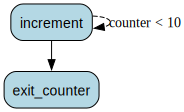

In [6]:
import datetime

from burr.core import action, State

@action(reads=["counter"], writes=["counter"])
def increment(state: State) -> State:
    """Increment the counter by 1"""
    current_count = state["counter"]  # get the value from the `state`
    current_count += 1
    print("Count: ", current_count)
    # use `.update()` to create a new `State`
    return state.update(counter=current_count)


@action(reads=["counter"], writes=[])
def exit_counter(state: State) -> State:
    """Print the current count and the current time"""
    current_count = state["counter"]
    print(f"Finished counting to {current_count} at {datetime.datetime.now():%H:%M:%S %Y-%m-%d}")
    return state

from burr.core import ApplicationBuilder, expr, default
from burr.core.graph import GraphBuilder
graph = (
    GraphBuilder()
    .with_actions(increment, exit_counter)
    .with_transitions(
        ("increment", "increment", expr("counter < 10")),
        ("increment", "exit_counter", default),
    ).build()
)
graph

In [7]:
# And run it!
app = (
    ApplicationBuilder()
    .with_graph(graph)
    .with_state(counter=0)
    .with_entrypoint("increment")
    .build()
)
action_obj, result, state = app.run(halt_after=["exit_counter"])

Count:  1
Count:  2
Count:  3
Count:  4
Count:  5
Count:  6
Count:  7
Count:  8
Count:  9
Count:  10
Finished counting to 10 at 22:56:42 2024-11-07


### V1. Given a LinkedIn PDF extract information from it.

```bash
cd email_assistant/v1
```

If you just want to play:
```bash
python app.py
```

If you want to write some code:
> Edit app.py to import `from pipeline import build_pipeline` and comment out importing `pipeline_gold`

> Edit pipeline.py

```bash
python app.py
```

#### Tasks:
- See what you can get the LLM to do
- Can you get it to extract information in a structured manner?
- What if you tweak the input prompt or data? How consistent is this behavior?
- What if you add more and more to be extracted? How well does it perform?

#### Recap:

1. This is a pipeline
2. Wouldn't it be great if we could get better structured output?

### Structured outputs with OpenAI via Pydantic

Output structure isn't guaranteed, but some models now have a way to provide structure that they would enforce.

Here we refresh our structured needs, and then show how to use pydantic and openai's new structured output API.

In [10]:
# Refresher
# set env key if you haven't
import os
#os.environ['OPENAI_API_KEY'] = .....

from openai import OpenAI

client = OpenAI()

news_wire = """
Today, Netflix (NFLX) jumped 5% on news of increased subscribers, ending the day at $123.45.
"""

completion = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {"role": "system", "content": "You are an excellent financial news information extractor that returns JSON."}, 
    {"role": "user", "content": f"Extract the company, stock ticker, and latest price from this newswire.\nNewswire:\n{news_wire}"},
  ]
)

print(completion.choices[0].message.content)

```json
{
  "company": "Netflix",
  "stock_ticker": "NFLX",
  "latest_price": 123.45
}
```


In [14]:
# New API:
from pydantic import BaseModel, Field
from openai import OpenAI

client = OpenAI()


class FinancialStockTicker(BaseModel):
    """Extract the following financial stock information."""
    company: str = Field(description="Company Name")
    stock_ticker: str = Field(description="Company stock ticker")
    latest_price: float = Field(description="The stock price at closing")


response = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
      {"role": "system", "content": "You are an excellent financial news information extractor that returns JSON."}, 
      {"role": "user", "content": f"Extract the company, stock ticker, and latest price from this newswire.\nNewswire:\n{news_wire}"},
    ],
    response_format=FinancialStockTicker,
)
ticker_result = response.choices[0].message.parsed
ticker_result

FinancialStockTicker(company='Netflix', stock_ticker='NFLX', latest_price=123.45)

In [16]:
ticker_result.company

'Netflix'

### V2. Given a LinkedIn PDF extract information and populate an email template using structured output

```bash
cd email_assistant/v2
```

If you just want to play:
```bash
python app.py
```

If you want to write some code:
> Edit app.py to import `from pipeline import build_pipeline` and comment out importing `pipeline_gold`

> Edit pipeline.py

> Edit test_pipeline.py

```bash
python app.py
pytest test_pipeline.py # or test_pipeline_gold.py
```

Tasks:
  - fill in the structured output
  - connect to email template
  - talk evaluating performance
  - write a unit test & discuss testing strategies / thoughts. Guardrails vs evaluations.

#### Recap:

1. This is a pipeline
2. Structured output
3. Testing is trickier -- need "guardrails" and "evaluations".

### V3. Adding in agent/agentic + Human-in-the-loops


```bash
cd email_assistant/v3
```

If you just want to play:
```bash
python app.py
```

If you want to write some code:
> Edit app.py to import `from pipeline import build_pipeline` and comment out importing `pipeline_gold`

> Edit pipeline.py

```bash
python app.py
```


Tasks:
  - add in conversation history 
  - play with the app
  - compare contrast with V2 from a productionization standpoint 
  - how to evaluate / test? (user edits?)



### V4. Ideas for extensions - for those that need it ->
- Adjust to provide a job description and ask the LLM for a fit
   - use CoT and other prompting techniques
- RAG: searching for a candidate given job reqs to send email to
- Function calling: get the weather given the location of the candidate


# Shapes of LLM usage: pipeline vs agentic + Human in the loop

## What is a pipeline?


## What is an agent? What is agentic? 

## What is Human in the loop?


# A start to an SDLC - by building out an app

![Alt text](img/3-llm-virtuous-cycle.png)

## Testing & evaluations

At a high level here are the things to think about.

### Dimensions:
#### micro 
You need to understand what each LLM call is doing. 
Easy for one, but picutre 60+ LLM calls.

#### macro
You need to place things into the context of the business and measure it. This is arguably most important else you have no way to measure efficacy or impact.

#### Guardrails
Help you keep / define the shape of your application. What you would likely run in CI.

#### Evaluations
You need to label & measure how it's performing in production. Examples here get added to guardrails.




# TODOs:

 - code to ingest eval output from burr (skip?)
 - make sure it all works on codespaces
 - slide with QR codes (repo, oai, course, burr)

In [2]:
# 